In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from desiutil.log import get_logger, DEBUG
log = get_logger()

import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='Set2')
%matplotlib inline

In [2]:
healpixel = 26030
nside = 64
seed = 555
rand = np.random.RandomState(seed)

In [3]:
from desitarget.mock.mockmaker import BGSMaker

In [4]:
from desisim.templates import BGS
def _default_wave(wavemin=None, wavemax=None, dw=0.2):
    """Generate a default wavelength vector for the output spectra."""
    from desimodel.io import load_throughput
    
    if wavemin is None:
        wavemin = load_throughput('b').wavemin - 10.0
    if wavemax is None:
        wavemax = load_throughput('z').wavemax + 10.0
            
    return np.arange(round(wavemin, 1), wavemax, dw)
#maker.template_maker = BGS(add_SNeIa=True,wave=_default_wave())

In [5]:
def plot_subset(wave, flux, truth, objtruth, nplot=16, ncol=4, these=None, 
                xlim=None, loc='right', targname='', objtype=''):
    """Plot a random sampling of spectra."""
    
    nspec, npix = flux.shape
    if nspec < nplot:
        nplot = nspec
    
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'
    
    if these is None:
        these = rand.choice(nspec, nplot, replace=False)
        these = np.sort(these)
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(objtruth['TEFF'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
        else:
            thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)
    
def demo_mockmaker(Maker, seed=None, nrand=16, loc='right'):

    TARGET = Maker(seed=seed)
    TARGET.template_maker = BGS(add_SNeIa=True,wave=_default_wave())
    log.info('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside)
    
    log.info('Generating {} random spectra.'.format(nrand))
    indx = rand.choice(len(tdata['RA']), np.min( (nrand, len(tdata['RA'])) ) )
    tflux, twave, ttargets, ttruth, tobjtruth = TARGET.make_spectra(tdata, indx=indx)
    
    log.info('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)
    
    plot_subset(twave, tflux, ttruth, tobjtruth, loc=loc, 
                targname=tdata['TARGET_NAME'], objtype=TARGET.objtype)
    
    return tflux, twave, ttargets, ttruth, tobjtruth

INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/bgs_templates_v2.2.fits
INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/bgs_templates_v2.2.fits
INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/sne_templates_v1.1.fits
INFO:<ipython-input-5-cd97770dd1b0>:46:demo_mockmaker: Reading the mock catalog for BGSs


/home/c-m/Software/anaconda3/envs/desi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:mockmaker.py:1957:_read_mockfile: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:1992:readmock: Trimmed to 2338 BGSs in 1 healpixel(s).
INFO:mockmaker.py:2033:readmock: Sampling from BGS Gaussian mixture model.
INFO:<ipython-input-5-cd97770dd1b0>:49:demo_mockmaker: Generating 16 random spectra.


/home/c-m/Software/anaconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


INFO:<ipython-input-5-cd97770dd1b0>:53:demo_mockmaker: Selecting targets


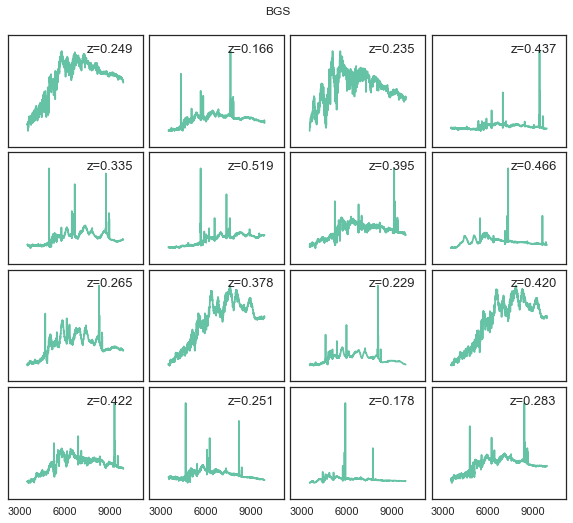

In [6]:
out = demo_mockmaker(BGSMaker)

In [7]:
out[-2]

TARGETID_1,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,TARGETID_2,SNE_TEMPLATEID,SNE_FLUXRATIO,SNE_EPOCH,SNE_FILTER
,,,,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,,,,,
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,str15,float32,float32,float32,float32,float32,int64,int64,float64,float32,str15
0,25499077,0,0.24903198,GALAXY,BGS,,7166,505646535,18.69951,sdss2010-r,11.395522,36.520626,61.87463,63.054733,49.371433,0,94,0.18964333665749045,76.0,decam2014-r
1,27496912,0,0.16591589,GALAXY,BGS,,7116,702617615,20.103683,sdss2010-r,4.242684,9.976406,16.627235,21.822342,18.499203,1,67,0.2664391598552604,49.0,decam2014-r
2,29906775,0,0.23479421,GALAXY,BGS,,3010,567188380,18.181742,sdss2010-r,27.713636,57.78555,94.88307,103.005974,81.29904,2,14,0.32701555344237127,-4.0,decam2014-r
3,22614311,0,0.43698236,GALAXY,BGS,,3396,2114836284,20.276157,sdss2010-r,3.0887687,8.420882,13.6227865,16.805305,13.5865345,3,68,0.14734733614238865,50.0,decam2014-r
4,30529263,0,0.33489257,GALAXY,BGS,,2078,1851377024,20.335049,sdss2010-r,3.0160763,7.925541,13.885374,11.960574,11.611997,4,46,0.568333502998085,28.0,decam2014-r
5,25168252,0,0.51910526,GALAXY,BGS,,6960,891568453,20.355278,sdss2010-r,1.9418523,8.691038,20.597769,34.782246,25.964672,5,41,0.4007418930610426,23.0,decam2014-r
6,27905217,0,0.39462042,GALAXY,BGS,,4165,1280230783,20.438978,sdss2010-r,2.6984258,7.067878,11.9598,18.731792,14.382042,6,18,0.21760246488537466,0.0,decam2014-r
7,27452380,0,0.46633294,GALAXY,BGS,,6343,1887927754,20.397266,sdss2010-r,3.2990968,6.9591722,9.122725,13.265778,11.020045,7,1,0.8952115861754134,-17.0,decam2014-r


In [8]:
maker = BGS(add_SNeIa=True)
output = maker.make_templates(10)

INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/bgs_templates_v2.2.fits
INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/sne_templates_v1.1.fits


/home/c-m/Software/anaconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [9]:
out[-2]

TARGETID_1,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,TARGETID_2,SNE_TEMPLATEID,SNE_FLUXRATIO,SNE_EPOCH,SNE_FILTER
,,,,,,,,,mag,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,,,,,
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,str15,float32,float32,float32,float32,float32,int64,int64,float64,float32,str15
0,25499077,0,0.24903198,GALAXY,BGS,,7166,505646535,18.69951,sdss2010-r,11.395522,36.520626,61.87463,63.054733,49.371433,0,94,0.18964333665749045,76.0,decam2014-r
1,27496912,0,0.16591589,GALAXY,BGS,,7116,702617615,20.103683,sdss2010-r,4.242684,9.976406,16.627235,21.822342,18.499203,1,67,0.2664391598552604,49.0,decam2014-r
2,29906775,0,0.23479421,GALAXY,BGS,,3010,567188380,18.181742,sdss2010-r,27.713636,57.78555,94.88307,103.005974,81.29904,2,14,0.32701555344237127,-4.0,decam2014-r
3,22614311,0,0.43698236,GALAXY,BGS,,3396,2114836284,20.276157,sdss2010-r,3.0887687,8.420882,13.6227865,16.805305,13.5865345,3,68,0.14734733614238865,50.0,decam2014-r
4,30529263,0,0.33489257,GALAXY,BGS,,2078,1851377024,20.335049,sdss2010-r,3.0160763,7.925541,13.885374,11.960574,11.611997,4,46,0.568333502998085,28.0,decam2014-r
5,25168252,0,0.51910526,GALAXY,BGS,,6960,891568453,20.355278,sdss2010-r,1.9418523,8.691038,20.597769,34.782246,25.964672,5,41,0.4007418930610426,23.0,decam2014-r
6,27905217,0,0.39462042,GALAXY,BGS,,4165,1280230783,20.438978,sdss2010-r,2.6984258,7.067878,11.9598,18.731792,14.382042,6,18,0.21760246488537466,0.0,decam2014-r
7,27452380,0,0.46633294,GALAXY,BGS,,6343,1887927754,20.397266,sdss2010-r,3.2990968,6.9591722,9.122725,13.265778,11.020045,7,1,0.8952115861754134,-17.0,decam2014-r


In [11]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

import pickle
import numpy as np
from datetime import datetime
import os

from matplotlib import pyplot as plt
from keras import regularizers, callbacks
from keras.utils.np_utils import to_categorical
from keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam
from keras.models import Model, load_model
from desispec.interpolation import resample_flux
from cnn import cnf_matrix,CNN
from jupyterthemes import jtplot

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
#plt.rcParamsDefault['axes.prop_cycle']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rc('grid',alpha=0.3,linestyle='--')

jtplot.style(theme='grade3')

Using TensorFlow backend.


#  Occlusion Test

In [13]:
with open('../data/bgs_elg_lrg_clean.bin','rb') as f:
    data = pickle.load(f)
    
np.random.seed(1)
farray = np.arange(len(data[2]))

indices_brightsne = farray[(data[2]['SNE_Type']==1)&
                           #(data[2]['SNE_RFLUXRATIO']<=.1)&
                          (data[2]['SNE_RFLUXRATIO']>=.001)]
indices_galaxies = farray[(data[2]['SNE_Type']==0)]


indices_brightsne2 = farray[(data[2]['SNE_Type']==2)&
                           #(data[2]['SNE_RFLUXRATIO']<=.1)&
                          (data[2]['SNE_RFLUXRATIO']>=.001)]


indices_gal = np.random.choice(indices_galaxies,25000,replace=False)
mask_gal = np.isin(farray,indices_gal)

indices_sne = np.random.choice(indices_brightsne,25000,replace=False)
mask_sne = np.isin(farray,indices_sne)

indices_sne2 = np.random.choice(indices_brightsne2,25000,replace=False)
mask_sne2 = np.isin(farray,indices_sne2)

mask = mask_gal | mask_sne | mask_sne2

ylabels = to_categorical(data[2]['SNE_Type'][mask])
#one_hot = to_categorical(ylabels)
x_train = data[0][mask].reshape(-1,400,1)

maxi = np.max(x_train,axis=1)
mini = np.min(x_train,axis=1)
standarized = (x_train.reshape(-1,400) - mini)/(maxi-mini)

a = np.random.permutation(len(x_train))

-4.0


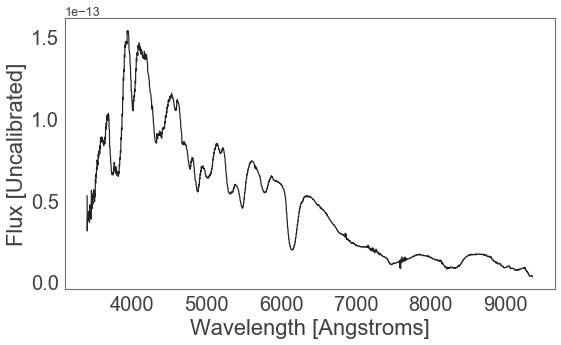

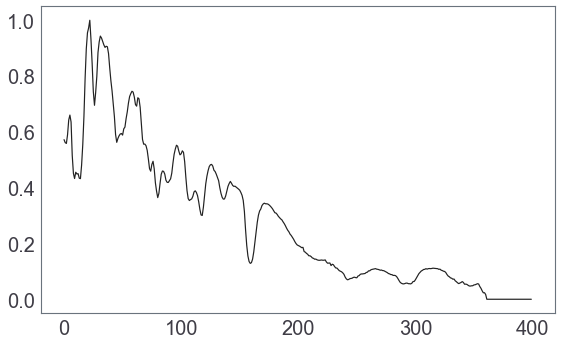

In [14]:
from json import load

with open('../data/transients/Ia/SN1994D.json', 'r') as f:
    file = load(f)
from astropy.time import Time
tmax = float(Time(file['SN1994D']['maxdate'][0]['value'].replace('/','-'),format='isot', scale='utc').mjd)
dict_s = file['SN1994D']['spectra'][27]
print(tmax - float(dict_s['time']))
wl = np.transpose(dict_s['data'])[0].astype('float')
fl =  np.transpose(dict_s['data'])[1].astype('float')

fig = plt.subplots(figsize=(8,5))
plt.plot(wl,fl,c='k')
plt.grid(False)
plt.xlabel('Wavelength [Angstroms]',fontsize=22)
plt.ylabel('Flux [Uncalibrated]',fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
#plt.savefig('../AAS/Ia.png', transparent=True)
fig = plt.subplots(figsize=(8,5))
flr = resample_flux(data[1][:400],wl,fl)
flr = (flr - min(flr)) / (max(flr) - min(flr))
plt.plot(flr,c='k')
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
#plt.savefig('../AAS/Ia_resampled.png', transparent=True)

## Load Model

In [15]:
model = load_model('../Tensorboard/cnn/models/97.hdf5')

In [17]:
#K.clear_session()
outputs = [layer.output for layer in model.layers]  
intermediate_model = Model(inputs=model.input,outputs=outputs)

out = model.predict([flr.reshape(-1,400,1)])
#out2 = intermediate_model.predict([flr2.reshape(-1,400,1)])

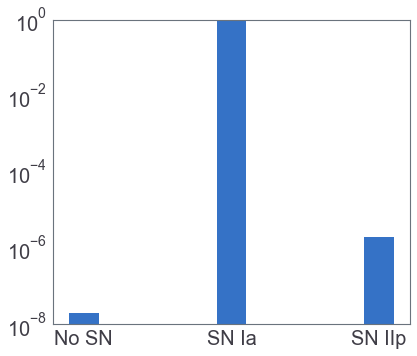

In [21]:
fig, ax = plt.subplots(1,1)
ax.bar([0,1,2], out[0],width=0.2)
ax.set_yscale('log')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['No SN', 'SN Ia', 'SN IIp'])
ax.set_ylim([1e-8,1])
ax.get_yticklabels()
ax.grid(False)
plt.tick_params(axis='both', which='major', labelsize=20)

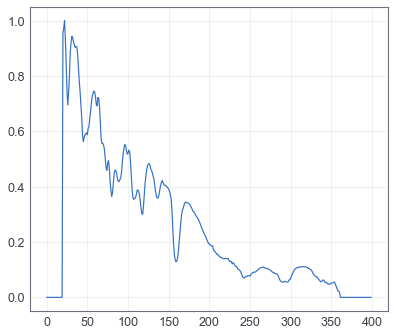

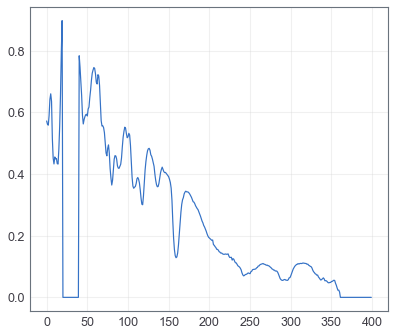

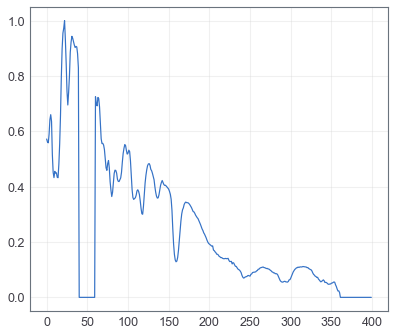

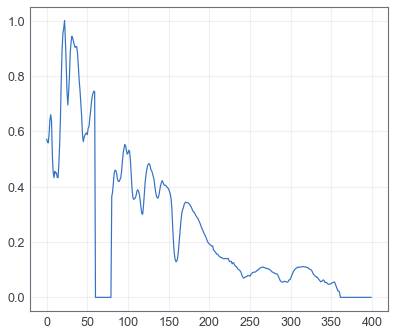

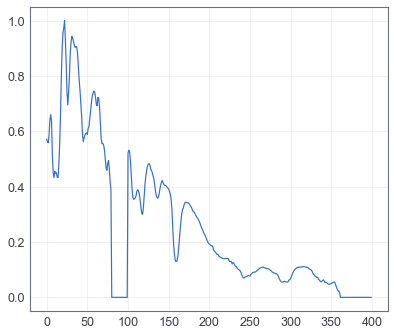

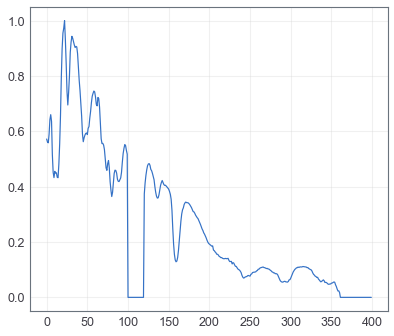

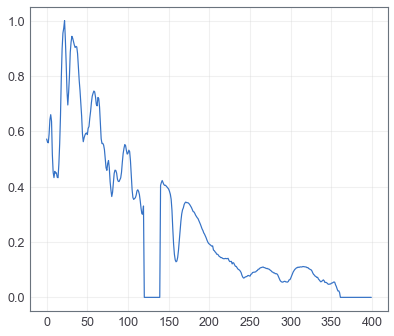

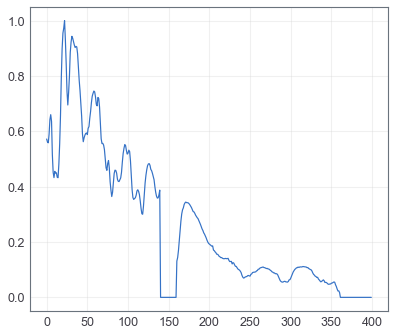

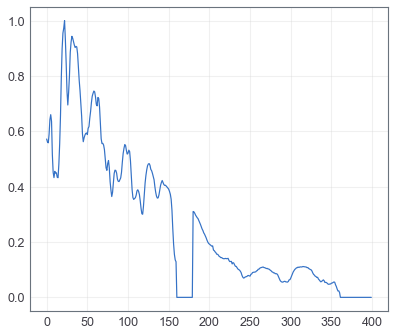

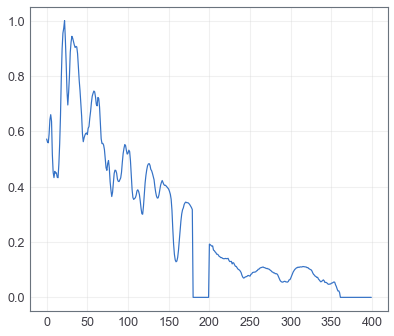

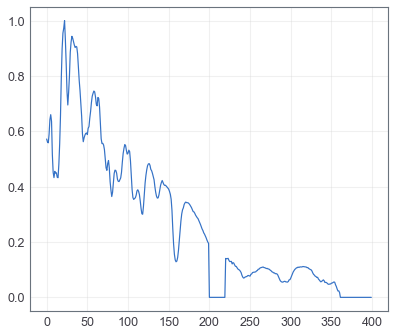

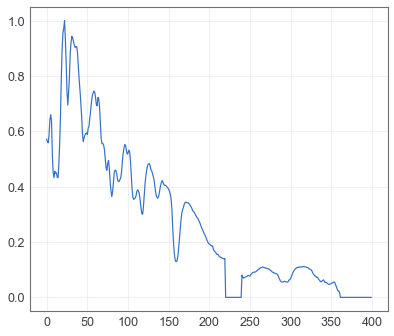

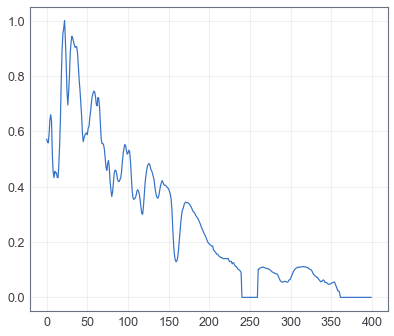

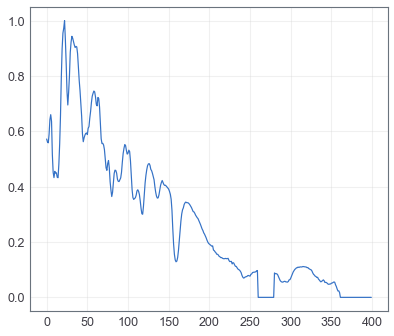

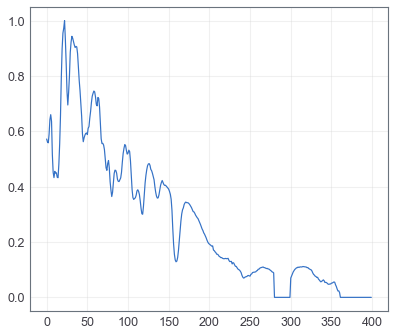

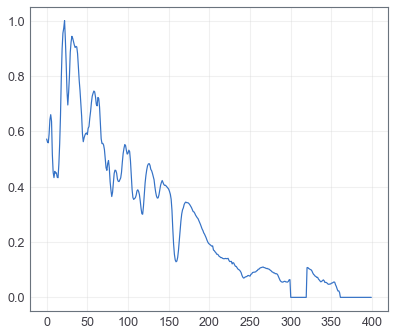

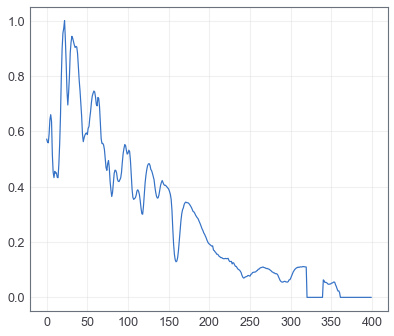

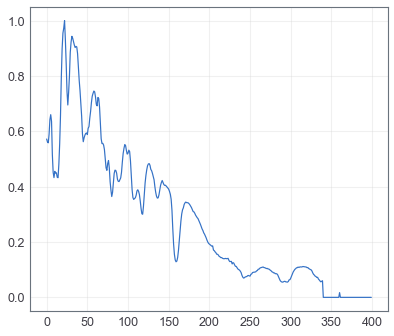

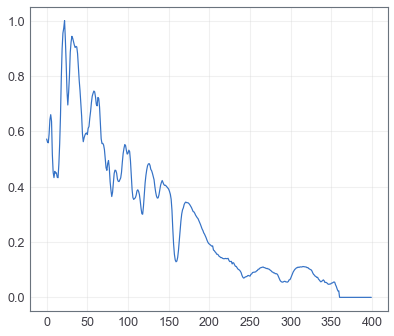

In [58]:
width = 20
indices = np.arange(0,400,width)

outs = []
for i in range(len(indices)-1):
    subspec = np.copy(flr)
    subspec[indices[i]:indices[i+1]] = 0
    plt.plot(subspec)
    plt.show()
    
    out = model.predict([subspec.reshape(-1,400,1)])
    outs.append(out)

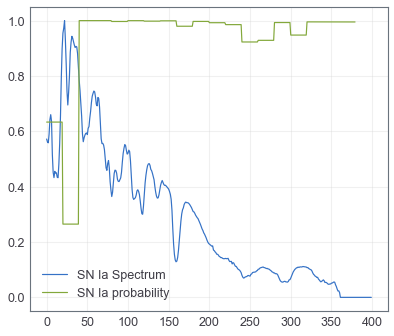

In [59]:
probsIa = np.repeat(np.array(outs).reshape(-1,3)[:,1],width)
probs = np.repeat(np.array(outs).reshape(-1,3)[:,0],width)
probsIIp = np.repeat(np.array(outs).reshape(-1,3)[:,2],width)
plt.plot(flr,label = 'SN Ia Spectrum')
plt.plot(probsIa,label='SN Ia probability')
#plt.plot(probs,label='No SN probability')
#plt.plot(probsIIp,label='SN IIp probability')
plt.legend()